In [2]:
import os
import matplotlib.cm as cm
import numpy as np
from notebookjs import execute_js
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import time
import tqdm
import json
import cv2
import glob 


# Camera Calibration

### Test difference in calibratrion metrics between scanning entire first 10 minutes and handpicking the good frames. Life is good iff I can just run a single job overnight.  

In [17]:
def scan_calibration_params(cap_path, start_frame=0, max_frames=300):
    '''
    Inputs:
    - cap (cv2.VideoCapture)
    - checkerboard (tuple pair)
    Returns:
    - calibration (list): [newcameramatrix, roi, ret, matrix, distortion, r_vecs, t_vecs]


    Currently this uses a reduced version of the video file where the
    '''


    cap = cv2.VideoCapture(cap_path) # access video

    # params
    CHECKERBOARD = (8,11) # chase checkerboard
    criteria = (cv2.TERM_CRITERIA_EPS + 
                cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) 
    
    threedpoints = [] 
    twodpoints = [] 
    
    #  3D points real world coordinates 
    objectp3d = np.zeros((1, CHECKERBOARD[0]  
                        * CHECKERBOARD[1],  
                        3), np.float32) 
    objectp3d[0, :, :2] = np.mgrid[0:CHECKERBOARD[0], 
                                0:CHECKERBOARD[1]].T.reshape(-1, 2) 
    prev_img_shape = None


    # run 
    for f in range(max_frames+start_frame):
        exists, frame = cap.read()

        if f<start_frame: pass
        else:
            if exists: # run locater if we get a valid frame
                h, w = frame.shape[:2] 
                grayColor = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
                ret, corners = cv2.findChessboardCorners( 
                        grayColor, CHECKERBOARD,  
                        cv2.CALIB_CB_ADAPTIVE_THRESH  
                        + cv2.CALIB_CB_FAST_CHECK + 
                        cv2.CALIB_CB_NORMALIZE_IMAGE)
                if ret == True: 
                    threedpoints.append(objectp3d) 

                    # Refining pixel coordinates 
                    # for given 2d points. 
                    corners2 = cv2.cornerSubPix( 
                        grayColor, corners, (11, 11), (-1, -1), criteria) 

                    twodpoints.append(corners2) 

                    # Draw and display the corners 
                    '''image_corners = cv2.drawChessboardCorners(frame,  
                                                        CHECKERBOARD,  
                                                        corners2, ret)'''
                    
                    '''plt.imshow(image_corners[:,:,::-1]) 
                    plt.show()'''
    

    ret, matrix, distortion, r_vecs, t_vecs = cv2.calibrateCamera(threedpoints, twodpoints, grayColor.shape[::-1], None, None) 
    newcameramatrix, roi = cv2.getOptimalNewCameraMatrix(matrix, distortion, (w,h), 1, (w,h))

    return {"new_matrix":newcameramatrix, "roi":roi, "ret":ret, "matrix":matrix, "distortion":distortion}

In [18]:
cap_path = "chase 1/half_res/left_half_1_calibration.mp4"
calibration_params = scan_calibration_params(cap_path)

In [21]:
# test undistort on single frame
cap = cv2.VideoCapture(cap_path)
_, frame = cap.read()

dst = cv2.undistort(frame, calibration_params['matrix'], calibration_params['distortion'], None, calibration_params['matrix'])

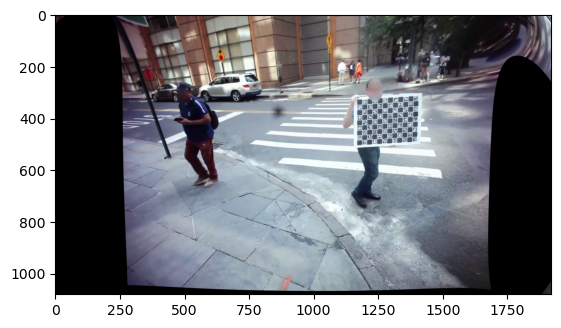

In [22]:
plt.imshow(dst[:,:,::-1]) 

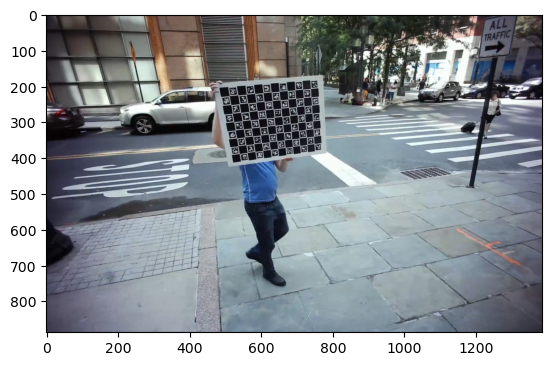

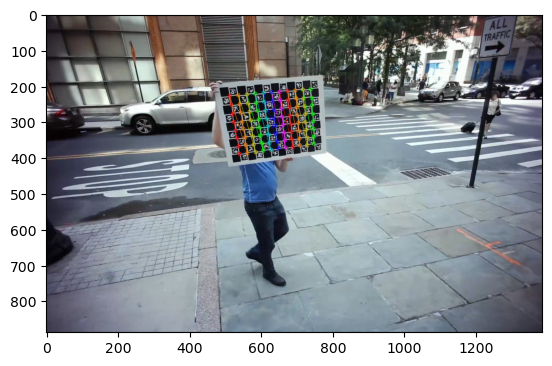

(887, 1386, 3)


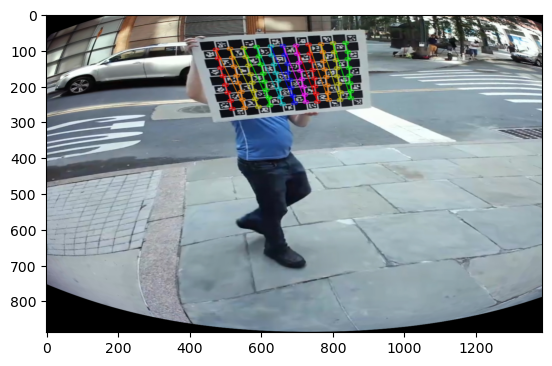

In [27]:
# finding chess board corners on image
CHECKERBOARD = (8,11)
image = cv2.imread('images/checkerboard.jpg') 
plt.imshow(image[:,:,::-1])
plt.show()
grayColor = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
# Find the chess board corners 
# If desired number of corners are 
# found in the image then ret = true 
ret, corners = cv2.findChessboardCorners( 
                grayColor, CHECKERBOARD,  
                cv2.CALIB_CB_ADAPTIVE_THRESH  
                + cv2.CALIB_CB_FAST_CHECK + 
                cv2.CALIB_CB_NORMALIZE_IMAGE) 

# If desired number of corners can be detected then, 
# refine the pixel coordinates and display 
# them on the images of checker board 
criteria = (cv2.TERM_CRITERIA_EPS + 
                cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) 
    
threedpoints = [] 
twodpoints = [] 

#  3D points real world coordinates 
objectp3d = np.zeros((1, CHECKERBOARD[0]  
                    * CHECKERBOARD[1],  
                    3), np.float32) 
objectp3d[0, :, :2] = np.mgrid[0:CHECKERBOARD[0], 
                            0:CHECKERBOARD[1]].T.reshape(-1, 2) 
prev_img_shape = None

if ret == True: 
    threedpoints.append(objectp3d) 

    # Refining pixel coordinates 
    # for given 2d points. 
    corners2 = cv2.cornerSubPix( 
        grayColor, corners, (11, 11), (-1, -1), criteria) 

    twodpoints.append(corners2) 

    # Draw and display the corners 
    image_corners = cv2.drawChessboardCorners(image,  
                                        CHECKERBOARD,  
                                        corners2, ret) 
    plt.imshow(image_corners[:,:,::-1]) 
    plt.show()

h, w = image.shape[:2] 
ret, matrix, distortion, r_vecs, t_vecs = cv2.calibrateCamera(threedpoints, twodpoints, grayColor.shape[::-1], None, None) 
newcameramatrix, roi = cv2.getOptimalNewCameraMatrix(matrix, distortion, (w,h), 1, (w,h))
dst = cv2.undistort(image, matrix, distortion, None, newcameramatrix)
print(dst.shape)
plt.imshow(dst[:,:,::-1])
plt.show()

In [21]:
# performing actual camera calibration
h, w = image.shape[:2] 

ret, matrix, distortion, r_vecs, t_vecs = cv2.calibrateCamera( 
    threedpoints, twodpoints, grayColor.shape[::-1], None, None) 
newcameramatrix, roi = cv2.getOptimalNewCameraMatrix(matrix, distortion, (w,h), 1, (w,h))

In [22]:
print(" Camera matrix:") 
print(matrix) 

print("\n New camera matrix:") 
print(newcameramatrix) 
  
print("\n Distortion coefficient:") 
print(distortion) 
  
print("\n Rotation Vectors:") 
print(r_vecs) 
  
print("\n Translation Vectors:") 
print(t_vecs) 

 Camera matrix:
[[692.92898915   0.         678.70287604]
 [  0.         615.46796705 536.01988973]
 [  0.           0.           1.        ]]

 New camera matrix:
[[1.14425606e+03 0.00000000e+00 7.41699986e+02]
 [0.00000000e+00 6.88201032e+02 4.17777626e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

 Distortion coefficient:
[[ 3.30143718e-02 -1.97498665e+00 -8.74118842e-02  3.71920977e-03
   4.26566887e+00]]

 Rotation Vectors:
(array([[ 0.50654575],
       [ 0.06352825],
       [-1.69522177]]),)

 Translation Vectors:
(array([[-6.15689856],
       [-7.12758657],
       [31.883199  ]]),)


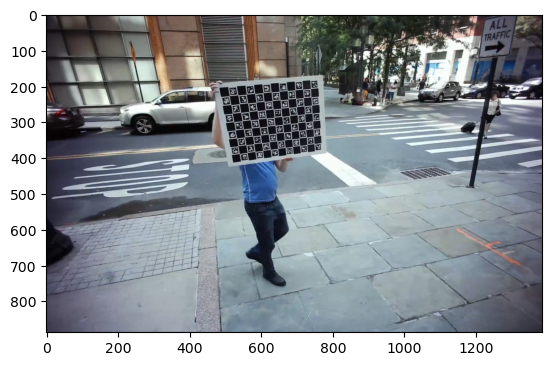

In [4]:
image = cv2.imread('images/checkerboard.jpg') 



# Homography Calculation (use Roboflow for labelling?)

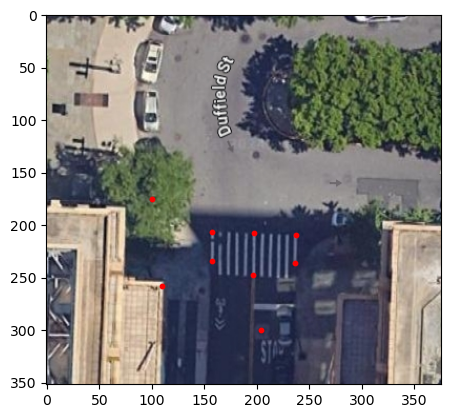

In [46]:
# show top down view of intersection
image_target = cv2.imread('images/chase_1_irl.jpg')
image_target = cv2.cvtColor(image_target, cv2.COLOR_BGR2RGB)
h, w, _ = image_target.shape

pairs_target = np.array([
    (237,209), # crosswalk top right
    (236,236), # bottom right
    (157,206), # top left
    (157,234), # bottom left
    (197,207), # top edge
    (196,247), # bottom edge

    (204,300), # manhole center
    (110,258), # corner of red building
    (100,175)# near tree
])


x_target = [pair[0] for pair in pairs_target]
y_target = [pair[1] for pair in pairs_target]

plt.imshow(image_target)
plt.scatter(x_target,y_target,s=10,c='red')
plt.show()

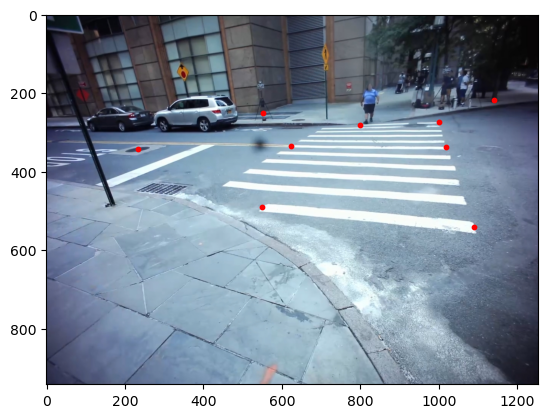

In [47]:
# show top down view of intersection
image_source = cv2.imread('images/chase_1_left_half.jpg')
image_source = cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB)
h, w, _ = image_source.shape

pairs_source = np.array([
    (1090,540), # crosswalk top right
    (549,490), # bottom right
    (999,274), # top left
    (800,280), # bottom left
    (1018,338), # top edge
    (624,333), # bottom edge

    (233,343), # manhole center
    (551,250), # corner of red building
    (1140,216) # near tree
])


x_source = [pair[0] for pair in pairs_source]
y_source = [pair[1] for pair in (pairs_source)]

plt.imshow(image_source)
plt.scatter(x_source,y_source,s=10,c='red')
plt.show()

In [63]:
'''
Homography is sensitive to repetitive points? reduce crosswalk
'''


H, mask = cv2.findHomography(pairs_source[2:], pairs_target[2:], cv2.RANSAC, 5.0)

In [64]:
warped_image = cv2.warpPerspective(image_source, H,(image_target.shape[1],image_target.shape[0]))

mask = np.where(warped_image<10,0,1)
combined_image = image_target.copy() 
combined_image[mask == 1] = warped_image[mask==1]



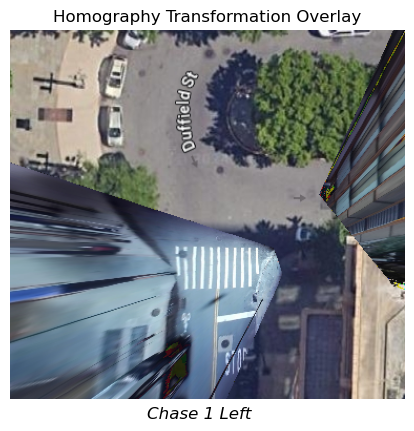

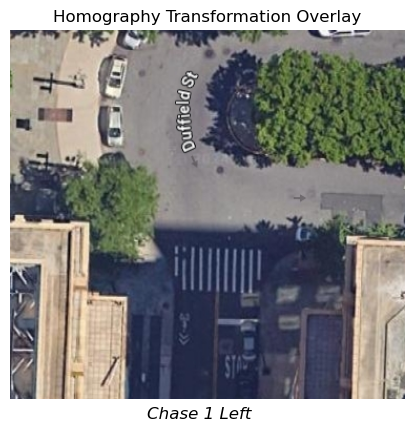

In [65]:
plt.imshow(combined_image)
plt.axis('off')
plt.title('Homography Transformation Overlay')
plt.figtext(0.5, 0.065, 'Chase 1 Left', ha='center', va='bottom', fontsize=12, style='italic')  # Adjust position and font size
plt.show()

plt.imshow(image_target)
plt.axis('off')
plt.title('Homography Transformation Overlay')
plt.figtext(0.5, 0.065, 'Chase 1 Left', ha='center', va='bottom', fontsize=12, style='italic')  # Adjust position and font size
plt.show()

## Vectorize the project points thing if its one pair at a time